In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from gensim.models import Word2Vec, KeyedVectors
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_excel("Womens Clothing Reviews Data.xlsx")

In [3]:
data = data.drop(columns = ['Product ID','Category','Subcategory1','SubCategory2','Location','Channel','Customer Age','Review Title', 'Recommend Flag'])

In [4]:
# === Convert Ratings to Binary Labels ===
# Positive: 4 or 5 -> 1
# Negative: 1 or 2 -> 0
# Drop 3-star ratings (neutral)
data = data[data['Rating'].isin([1, 2, 4, 5])]
data['Sentiment'] = data['Rating'].apply(lambda x: 1 if x >= 4 else 0)

In [5]:
data = data.drop(columns = ['Rating'])

In [6]:
data = data.dropna()

In [13]:
data

,Review Text,Sentiment
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,1
3,"I love, love, love this jumpsuit. it's fun, fl...",1
4,This shirt is very flattering to all due to th...,1
5,"I love tracy reese dresses, but this one is no...",0
...,...,...
23477,I'm so impressed with the beautiful color comb...,1
23478,I was surprised at the positive reviews for th...,0
23479,So i wasn't sure about ordering this skirt bec...,1
23481,I was very happy to snag this dress at such a ...,1


In [7]:
import re
import nltk
nltk.download('stopwords')  
nltk.download('wordnet')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ysnit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ysnit\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
# Importing pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.nn.utils.rnn import pad_sequence
import string

In [9]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = re.sub(r'[^\w\s]', '', str(text).lower())
    tokens = word_tokenize(text)
    return [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]

data['processed'] = data['Review Text'].apply(preprocess)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
# === 3. Train Word2Vec and Convert to Sequences ===
def train_word2vec(corpus, vector_size=100):
    return Word2Vec(sentences=corpus, vector_size=vector_size, window=5, min_count=2, workers=4)

w2v_model = train_word2vec(data['processed'].tolist())
pretrained_embeddings = w2v_model.wv.vectors
embedding_dim = pretrained_embeddings.shape[1]
vocab_size = pretrained_embeddings.shape[0]
word2idx = w2v_model.wv.key_to_index


In [12]:
# Padding Sequences
def texts_to_sequences(texts, word2idx):
    return [[word2idx[word] for word in text if word in word2idx] for text in texts]

sequences = texts_to_sequences(data['processed'], word2idx)
sequences_padded = pad_sequence([torch.tensor(seq) for seq in sequences], batch_first=True, padding_value=0).to(device)
labels = torch.tensor(data['Sentiment'], dtype=torch.long).to(device)

In [13]:
# === 4. Dataset and Dataloaders ===
dataset = TensorDataset(sequences_padded, labels)
train_len = int(0.8 * len(dataset))
test_len = len(dataset) - train_len
train_ds, test_ds = random_split(dataset, [train_len, test_len])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)

In [22]:
# === 5. GRU Model Definition ===
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size=128, num_layers=2, pretrained_embeddings=None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(torch.tensor(pretrained_embeddings))
            self.embedding.weight.requires_grad = True
            
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=0.3)
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1),
            nn.Softmax(dim=1)
        )
        
        self.fc = nn.Linear(hidden_size * 2, 2)  # Binary classification
        self.dropout = nn.Dropout(0.5)
        self.norm = nn.LayerNorm(hidden_size * 2)
        
    def forward(self, x):
        x = x.long()
        x = self.embedding(x)
        
        # Create initial hidden state
        h0 = torch.zeros(self.gru.num_layers * 2, x.size(0), self.gru.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        
        # Apply attention mechanism instead of just taking the last hidden state
        attention_weights = self.attention(out)
        context_vector = torch.sum(attention_weights * out, dim=1)
        
        # Apply normalization and dropout
        context_vector = self.norm(self.dropout(context_vector))
        
        # Final classification layer
        logits = self.fc(context_vector)
        return logits

In [28]:
# Hyperparameters for model
def initialize_model(vocab_size, embedding_dim, pretrained_embeddings):
    # Consistent hyperparameters
    hidden_size = 128
    num_layers = 2  # Make sure this matches what's used in the model constructor
    
    model = GRUModel(
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        hidden_size=hidden_size,
        num_layers=num_layers,
        pretrained_embeddings=pretrained_embeddings
    ).to(device)
    
    return model


In [31]:
# First initialize your model
model = GRUModel(
    vocab_size=vocab_size,  # Replace with your actual vocab size
    embedding_dim=embedding_dim,  # Replace with your embedding dimension
    pretrained_embeddings=pretrained_embeddings  # Your embeddings or None
)

# If you've trained the model, make sure that's done before saving

# 2. Load the saved weights
model.load_state_dict(torch.load('gru_model.pth'))

# 3. Set the model to evaluation mode
model.eval()

GRUModel(
  (embedding): Embedding(7811, 100, padding_idx=0)
  (gru): GRU(100, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (attention): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Softmax(dim=1)
  )
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
)

In [28]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [32]:
# === 6. Train the Model ===
# === 3. IMPROVED TRAINING FUNCTION ===
def train_model(model, train_loader, test_loader, epochs=20, lr=0.0005):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)  # Changed to AdamW with better weight decay
    
    # More effective learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True
    )
    
    # Better early stopping with more patience
    patience = 5  # Increased from 3
    wait = 0  # Initialize the wait variable
    best_val_loss = float('inf')
    best_model_state = None
    
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []
    
    for epoch in range(epochs):
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item()
            _, pred = out.max(1)
            train_correct += (pred == y).sum().item()
            train_total += y.size(0)

        model.eval()
        test_loss, test_correct, test_total = 0, 0, 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                test_loss += loss.item()
                _, pred = out.max(1)
                test_correct += (pred == y).sum().item()
                test_total += y.size(0)

        avg_train_loss = train_loss / len(train_loader)
        avg_test_loss = test_loss / len(test_loader)
        train_acc = 100 * train_correct / train_total
        test_acc = 100 * test_correct / test_total
        
        # Store metrics for plotting
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        
        # Update scheduler
        scheduler.step(avg_test_loss)

        print(f"Epoch {epoch+1:03d} | Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f} | "
              f"Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}% | LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Early stopping logic with model saving
        improved = avg_test_loss < best_val_loss
        if improved:
            best_val_loss = avg_test_loss
            best_model_state = model.state_dict().copy()
            wait = 0
            print(f"✓ New best model saved (loss: {best_val_loss:.4f})")
        else:
            wait += 1
            print(f"◌ No improvement for {wait}/{patience} epochs")

        if wait >= patience:
            print(f"\n⚠️ Early stopping at epoch {epoch+1}. No improvement for {patience} epochs.")
            break


In [33]:
# === 7. Initialize and Train ===
model = GRUModel(vocab_size, embedding_dim, pretrained_embeddings=pretrained_embeddings).to(device)
train_model(model, train_loader, test_loader, epochs=20, lr=0.0005)


Epoch 001 | Train Loss: 0.2476 | Test Loss: 0.1959 | Train Acc: 90.13% | Test Acc: 91.73% | LR: 0.000500
✓ New best model saved (loss: 0.1959)
Epoch 002 | Train Loss: 0.1778 | Test Loss: 0.1795 | Train Acc: 92.89% | Test Acc: 93.19% | LR: 0.000500
✓ New best model saved (loss: 0.1795)
Epoch 003 | Train Loss: 0.1366 | Test Loss: 0.1796 | Train Acc: 94.74% | Test Acc: 93.39% | LR: 0.000500
◌ No improvement for 1/5 epochs
Epoch 004 | Train Loss: 0.1087 | Test Loss: 0.2341 | Train Acc: 95.79% | Test Acc: 92.91% | LR: 0.000500
◌ No improvement for 2/5 epochs
Epoch 005 | Train Loss: 0.0898 | Test Loss: 0.2251 | Train Acc: 96.73% | Test Acc: 93.69% | LR: 0.000250
◌ No improvement for 3/5 epochs
Epoch 006 | Train Loss: 0.0533 | Test Loss: 0.3595 | Train Acc: 98.20% | Test Acc: 92.61% | LR: 0.000250
◌ No improvement for 4/5 epochs
Epoch 007 | Train Loss: 0.0433 | Test Loss: 0.3017 | Train Acc: 98.64% | Test Acc: 93.49% | LR: 0.000250
◌ No improvement for 5/5 epochs

⚠️ Early stopping at epoch 7

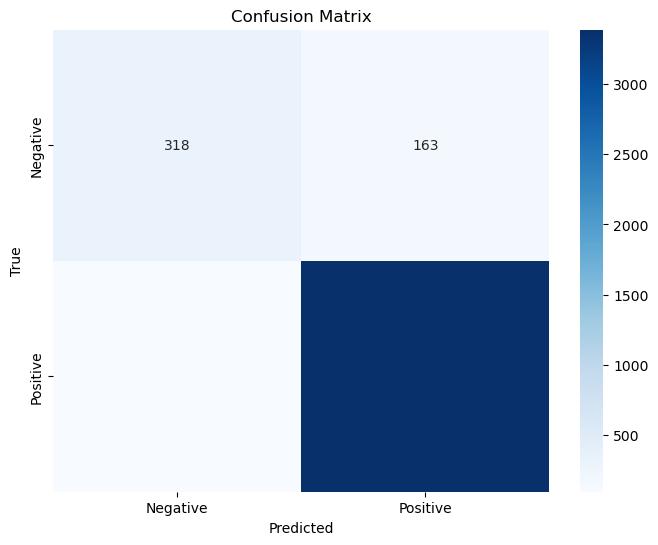

In [42]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        _, preds = torch.max(outputs, 1)
        
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Now the confusion matrix code will work
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [43]:
# === 7. INFERENCE FUNCTION ===
# Add this function to make predictions on new text
def predict_sentiment(model, text, word2idx, preprocess_fn):
    model.eval()
    
    # Preprocess the text
    tokens = preprocess_fn(text)
    
    # Convert to sequence
    sequence = [word2idx[word] for word in tokens if word in word2idx]
    
    # Handle empty sequence
    if not sequence:
        return "Unable to predict (no recognized words)"
    
    # Create tensor and add batch dimension
    tensor = torch.tensor([sequence]).to(device)
    
    # Get prediction
    with torch.no_grad():
        output = model(tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        prediction = torch.argmax(output, dim=1).item()
    
    sentiment = "Positive" if prediction == 1 else "Negative"
    confidence = probabilities[0][prediction].item() * 100
    
    return f"Sentiment: {sentiment} (Confidence: {confidence:.2f}%)"

In [44]:
import pickle

def save_model_as_pickle(model, word2idx, filename='gru_sentiment_model.pkl'):
    # Create a dictionary of everything you want to save
    model_data = {
        'model_state_dict': model.state_dict(),
        'word2idx': word2idx,
        'model_config': {
            'vocab_size': len(word2idx),
            'embedding_dim': model.embedding.embedding_dim,
            'hidden_size': model.gru.hidden_size,
            'num_layers': model.gru.num_layers,
        }
    }
    
    # Save to pickle file
    with open(filename, 'wb') as f:
        pickle.dump(model_data, f)
    
    print(f"Model saved as pickle to {filename}")

# Usage
save_model_as_pickle(model, word2idx)

Model saved as pickle to gru_sentiment_model.pkl


### Training on GRU


3. Model Comparison:
Compare the performance of the two models using the metrics you calculated (e.g., accuracy). This helps in selecting the best-performing model for further use.
Consider other factors such as training time and computational resources needed by each model.
4. Hyperparameter Tuning:
If you think the models can be improved, consider tuning hyperparameters like learning rate (lr), batch size, or even the architecture of the model (e.g., increasing the number of layers, changing hidden size, etc.).
You can use techniques like GridSearch or Random Search, or even more advanced methods like Bayesian Optimization for hyperparameter optimization.
5. Model Regularization:
If your models are overfitting (i.e., if the training loss is much lower than the test loss), consider using regularization methods:
Dropout: Adding dropout layers can help prevent overfitting by randomly deactivating certain neurons during training.
Weight Decay: Adding weight decay (L2 regularization) to your optimizer can help prevent the model from fitting too closely to the training data.
Example of adding dropout:
python
Copy
self.dropout = nn.Dropout(p=0.5)  # Add dropout in your model architecture
6. Early Stopping:
Implement early stopping to stop training once the test loss stops improving. This prevents unnecessary training epochs and can save computational resources.
You can monitor the test loss and stop when it stops improving for a certain number of epochs.
7. Save and Load Models:
Once you've trained the models and evaluated their performance, you can save them for later use:
python
Copy
torch.save(lstm_model.state_dict(), 'lstm_model.pth')
torch.save(gru_model.state_dict(), 'gru_model.pth')
You can later load the model with:
python
Copy
lstm_model.load_state_dict(torch.load('lstm_model.pth'))
gru_model.load_state_dict(torch.load('gru_model.pth'))
8. Model Inference/Prediction:
Use the trained models to make predictions on new, unseen data. Ensure that the data is preprocessed in the same way as your training and test data.
python
Copy
new_data = preprocess_data(raw_input_data)
model.eval()
with torch.no_grad():
    prediction = model(new_data)
predicted_class = torch.argmax(prediction, dim=1)
9. Deploy the Model (if applicable):
If the goal is to deploy the model for real-world use, you may want to wrap the model into a REST API using frameworks like Flask or FastAPI, and deploy it on a server or cloud platform (AWS, GCP, Azure).
10. Model Interpretability:
For some use cases, you might need to interpret the predictions of the model. You can use techniques such as:
SHAP (SHapley Additive exPlanations) to explain the model’s predictions.
LIME (Local Interpretable Model-agnostic Explanations) for local model explanations.
11. Further Improvements:
Depending on the results, you might want to consider additional steps such as:
Data Augmentation if the dataset is small or imbalanced.
Ensemble methods to combine multiple models and improve performance.
Transfer learning by using pre-trained models for feature extraction or fine-tuning.
By following these steps, you can refine the models, test their performance thoroughly, and make them ready for deployment or further improvements.
